# Seed labeling with scANVI
In this tutorial, we go through the steps of training scANVI for seed annotation. This is useful for when we have ground truth labels for a few cells and want to annotate unlabelled cells. For more information, please refer to the original [scANVI publication](https://www.biorxiv.org/content/biorxiv/early/2019/01/29/532895.full.pdf). 

Plan for this tutorial:

1. Loading the data
2. Creating the seed labels: groundtruth for a small fraction of cells
2. Training the scANVI model: transferring annotation to the whole dataset
3. Visualizing the latent space and predicted labels

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import scanpy as sc
import numpy as np
from scipy import sparse

import torch
import scvi

import matplotlib.pyplot as plt
import matplotlib

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data Loading

For the purposes of this notebook, we will be labeling 4 cell types in a dataset of purified peripheral blood mononuclear cells from 10x Genomics:
+ CD4 Regulatory T cells
+ CD4 Naive T cells
+ CD4 Memory T cells
+ CD8 Naive T cells





In [3]:
adata = scvi.data.purified_pbmc_dataset(subset_datasets=["regulatory_t", "naive_t", "memory_t", "naive_cytotoxic"])

INFO     File data/PurifiedPBMCDataset.h5ad already downloaded                               


From now on, we assume that cell type information for each cell is unavailable to us, and we seek to retrieve it.

## Automatic annotation using seed labels

In this section we hand curate and select cells which will serve as our ground truth labels.

We start by putting together a list of curated marker genes, from which we aim at identifying our ground truth cell types. These are extracted from the scANVI publication.




In [4]:
gene_subset = ["CD4", "FOXP3", "TNFRSF18", "IL2RA", "CTLA4", "CD44", "TCF7", "CD8B", "CCR7", "CD69", "PTPRC", "S100A4"]

Then, we assign a score to every cell as a function of its cell type signature. In order to compute these scores, we need to normalize the data. Because this is not the case of scVI or scANVI, we proceed with a copy of the dataset for this step.

In [5]:
normalized = adata.copy()
sc.pp.normalize_total(normalized, target_sum = 1e4) 
sc.pp.log1p(normalized)

normalized = normalized[:,gene_subset].copy()
sc.pp.scale(normalized)

Now, here we have two helper functions that will help in scoring the cells, as well as taking the most confident cells with respect to these scores.

In [6]:
def get_score(normalized_adata, gene_set):
    """Returns the score per cell given a dictionary of + and - genes

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score
    
    Returns
    -------
    array of length of n_cells containing the score per cell
    """
    score = np.zeros(normalized_adata.n_obs)
    for gene in gene_set['positive']:
        expression = np.array(normalized_adata[:, gene].X)
        score += expression.flatten()
    for gene in gene_set['negative']:
        expression = np.array(normalized_adata[:, gene].X)
        score -= expression.flatten()
    return score

def get_cell_mask(normalized_adata, gene_set):
    """Calculates the score per cell for a list of genes, then returns a mask for
    the cells with the highest 50 scores. 

    Parameters
    ----------
    normalized_adata
      anndata dataset that has been log normalized and scaled to mean 0, std 1
    gene_set
      a dictionary with two keys: 'positive' and 'negative'
      each key should contain a list of genes
      for each gene in gene_set['positive'], its expression will be added to the score
      for each gene in gene_set['negative'], its expression will be subtracted from its score
    
    Returns
    -------
    Mask for the cells with the top 50 scores over the entire dataset
    """
    score = get_score(normalized_adata, gene_set)
    cell_idx = score.argsort()[-50:]
    mask = np.zeros(normalized_adata.n_obs)
    mask[cell_idx] = 1
    return mask.astype(bool)

We run those function to identify highly confident cells, that we aim at using as seed labels

In [7]:
#hand curated list of genes for identifying ground truth

cd4_reg_geneset = {"positive":["TNFRSF18", "CTLA4", "FOXP3", "IL2RA"],
                   "negative":["S100A4" ,"PTPRC" ,"CD8B"]}

cd8_naive_geneset = {"positive":["CD8B", "CCR7"],
                   "negative":["CD4"]}

cd4_naive_geneset = {"positive":["CCR7","CD4"],
                   "negative":["S100A4", "PTPRC", "FOXP3", "IL2RA", "CD69" ]}

cd4_mem_geneset = {"positive":["S100A4"],
                   "negative":["IL2RA" ,"FOXP3","TNFRSF18", "CCR7"]}

In [8]:
cd4_reg_mask = get_cell_mask(normalized, cd4_reg_geneset,) 
cd8_naive_mask = get_cell_mask(normalized, cd8_naive_geneset,) 
cd4_naive_mask = get_cell_mask(normalized, cd4_naive_geneset,)
cd4_mem_mask = get_cell_mask(normalized, cd4_mem_geneset,)

In [9]:
seed_labels = np.array(cd4_mem_mask.shape[0] * ["Unknown"])
seed_labels[cd8_naive_mask] = "CD8 Naive T cell"
seed_labels[cd4_naive_mask] = "CD4 Naive T cell"
seed_labels[cd4_mem_mask] = "CD4 Memory T cell"
seed_labels[cd4_reg_mask] = "CD4 Regulatory T cell"

adata.obs["seed_labels"] = seed_labels

We can observe what seed label information we have now

In [10]:
adata.obs.seed_labels.value_counts()

Unknown    42719
CD4 Reg       50
CD4 Nai       50
CD4 Mem       50
CD8 Nai       50
Name: seed_labels, dtype: int64

As expected, we use 50 cells for each cell type!

### Transfer of annotation with scANVI

As in the harmonization notebook, we need to register the AnnData object for use in scANVI. Namely, we can ignore the batch parameter because those cells don't have much batch effect to begin with. However, we will give the seed labels for scANVI to use.

In [11]:
scvi.model.SCVI.setup_anndata(adata, batch_key=None, labels_key="seed_labels")

In [12]:
scvi_model = scvi.model.SCVI(adata, n_latent=30, n_layers=2)

In [13]:
scvi_model.train(100)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [05:13<00:00,  3.13s/it, loss=1.75e+03, v_num=1]


Now we can train scANVI and transfer the labels!

In [14]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

/home/adam/Documents/software/scvi-tools/scvi/model/_scanvi.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  labels == self.unlabeled_category_
/home/adam/Documents/software/scvi-tools/scvi/model/_scanvi.py:255: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  self._labeled_indices = np.argwhere(labels != self.unlabeled_category_).ravel()


In [15]:
scanvi_model.train(25)

INFO     Training for 25 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 25/25: 100%|██████████| 25/25 [02:25<00:00,  5.83s/it, loss=1.77e+03, v_num=1]


Now we can predict the missing cell types, and get the latent space


In [16]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [17]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'seed_labels' as categorical
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'C_scANVI' as categorical


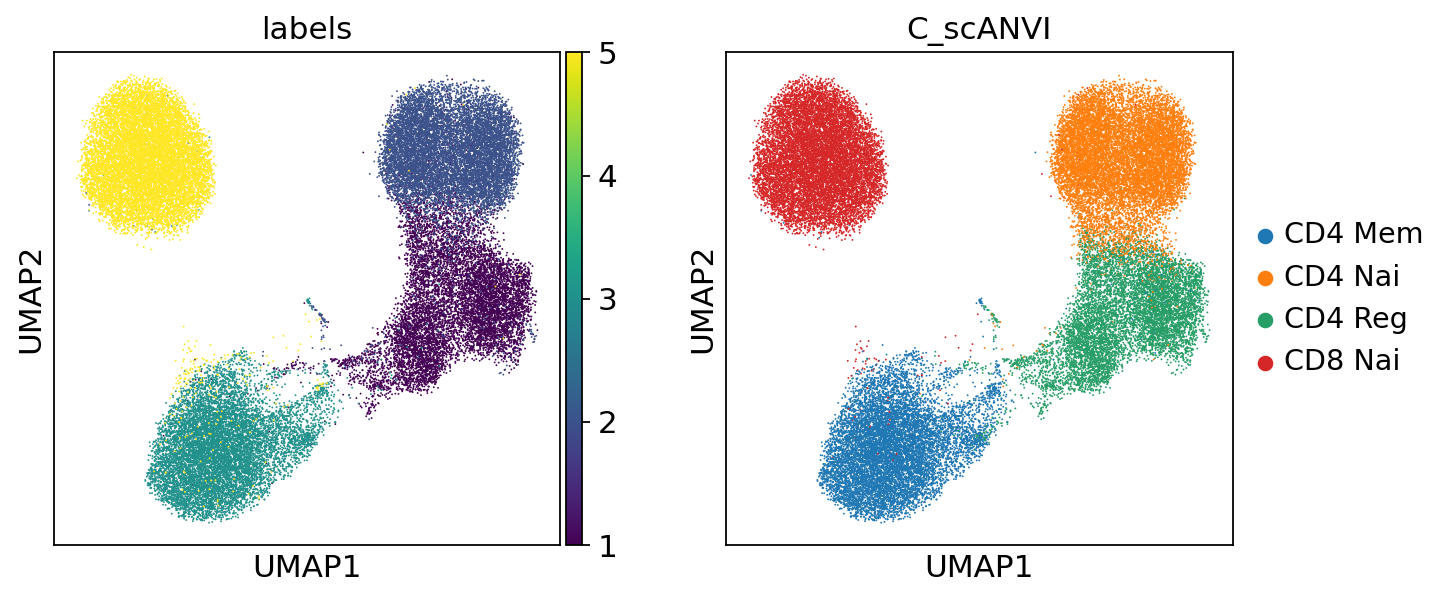

In [18]:
sc.pl.umap(adata, color=['labels', 'C_scANVI'])

From this, we can see that it is relatively easy for scANVI to separate the CD4 T cells from the CD8 T cells (in latent space, as well as for the classifier). The regulatory CD4 T cells are sometimes missclassified into CD4 Naive, but this stays a minor phenomenon. Also, we expect that better results may be obtained by careful hyperparameter selection for the classifier. Learn about all of this in our [documentation](https://scvi.readthedocs.io/en/stable/). 